<a href="https://colab.research.google.com/github/Marcellinus08/Deep-Learning/blob/main/DeteksiSarkasme_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import json

Load dan Cek Dataset
python
Copy
Edit


In [40]:
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json'
df = pd.read_json(url, lines=True)
df.head()
df.dropna(inplace=True)

Preprocessing

In [41]:
tokenizer = Tokenizer(num_words=30000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['headline'])

sequences = tokenizer.texts_to_sequences(df['headline'])
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

X = padded
y = df['is_sarcastic'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

MODEL BUILDING FUNCTION




In [42]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=30000, output_dim=hp.Int('embedding_dim', 32, 128, step=32)))
    model.add(Bidirectional(SimpleRNN(units=hp.Int('rnn_units', 32, 128, step=32), return_sequences=False)))
    model.add(Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units', 32, 128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate2', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


HYPERPARAMETER TUNING

In [43]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='sarkasme_birnn'
)

tuner.search(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

Trial 5 Complete [00h 00m 34s]
val_accuracy: 0.850257396697998

Best val_accuracy So Far: 0.8596162796020508
Total elapsed time: 00h 04m 41s


BEST HYPERPARAMETERS

In [44]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print("=== Best Configuration ===")
print(f"Embedding Dim: {best_hps.get('embedding_dim')}")
print(f"RNN Units: {best_hps.get('rnn_units')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dropout 1: {best_hps.get('dropout_rate')}")
print(f"Dropout 2: {best_hps.get('dropout_rate2')}")
print(f"Optimizer: {best_hps.get('optimizer')}")

=== Best Configuration ===
Embedding Dim: 64
RNN Units: 128
Dense Units: 96
Dropout 1: 0.30000000000000004
Dropout 2: 0.30000000000000004
Optimizer: rmsprop


TRAIN BEST MODEL

In [45]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.5695 - loss: 0.6815 - val_accuracy: 0.7705 - val_loss: 0.4792
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - accuracy: 0.8334 - loss: 0.3721 - val_accuracy: 0.8503 - val_loss: 0.4016
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.8798 - loss: 0.3161 - val_accuracy: 0.8105 - val_loss: 0.4184
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9257 - loss: 0.1997 - val_accuracy: 0.8318 - val_loss: 0.4091
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9580 - loss: 0.1224 - val_accuracy: 0.8582 - val_loss: 0.3864
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9758 - loss: 0.0762 - val_accuracy: 0.8596 - val_loss: 0.4522
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9644 - loss: 0.1115 - val_accuracy: 0.8512 - val_loss: 0.4920
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.9833 - loss: 0.0488 - v

EVALUATION

In [46]:
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("\n=== Evaluation Metrics ===")
print(f"Akurasi: {acc:.4f}")
print(f"Presisi: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Squared: {f1:.4f}")
print(f"AUC: {auc:.4f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

=== Evaluation Metrics ===
Akurasi: 0.8446
Presisi: 0.8477
Recall: 0.7877
F1 Squared: 0.8166
AUC: 0.9242


VISUALISASI AKURASI & LOSS

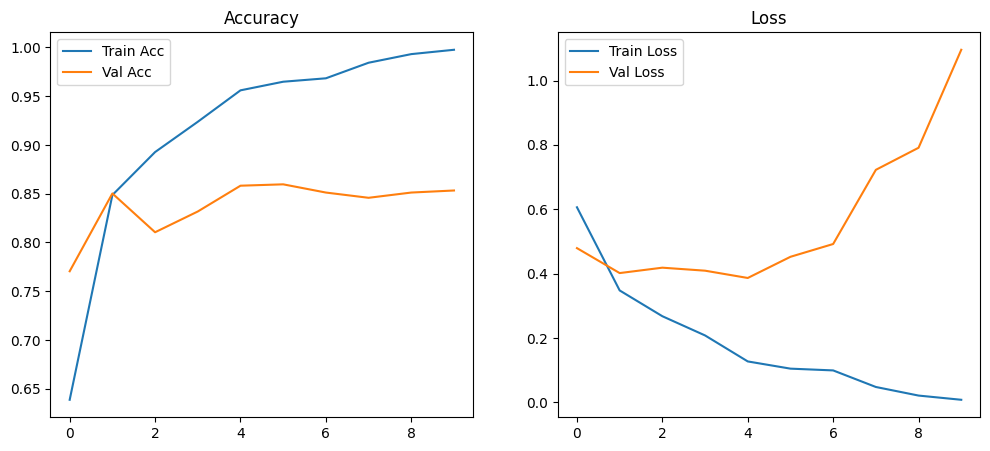

In [47]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

ROC CURVE

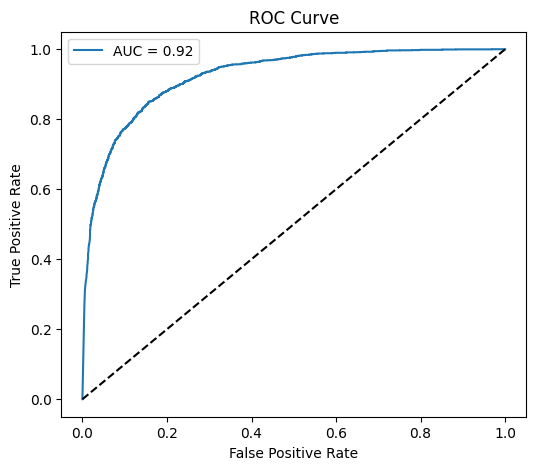

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()